Aprendizaje profundo con el dataset [titanic](https://www.kaggle.com/c/titanic/).

> El hundimiento del Titanic es una de las tragedias marítimas más conocidas de la historia. El 15 de abril de 1912, durante su viaje inaugural, el Titanic se hundió después de chocar contra un iceberg. En el accidente murieron 1502 personas de las 2224 que habían embarcado, incluyendo pasajeros y tripulación. Una de las razones por las que no se encontraron más supervivientes fue la falta de espacio en los barcos salvavidas. Así, aunque la suerte sin duda sonrió a los supervivientes, también resultaron más favorecidos algunos grupos de personas, como las mujeres, los niños y los pasajeros de la clase superior

# Instalación de paquetes

In [18]:
install.packages("keras")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




# Particionamiento de datos

In [19]:
library(tidyverse)
library(caret)
data <- read_csv('titanic.csv') %>%
  select(Survived, Pclass, Sex, Age, Fare) %>%
  mutate(Sex = as.numeric(as.factor(Sex)) - 1) %>%
  na.omit()

library(caret)
trainIndex <- createDataPartition(data$Survived, p = .7, list = FALSE)[,1]  ## Atencion: [,1] para versiones de tibble >= 3.0
train      <- data[trainIndex, ] 
val        <- data[-trainIndex, ]

x_train <- train %>%
  select(-Survived) %>%
  data.matrix()

y_train <- train %>%
  select(Survived) %>%
  data.matrix()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Entrenamiento de modelo



## Definición de red neuronal

In [14]:
library(keras)
model <- keras_model_sequential() %>% 
  layer_dense(units = 32, activation = "relu", input_shape = c(ncol(data) - 1)) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid")
model

Model: "sequential_3"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_8 (Dense)                    (None, 32)                      160         
 dense_7 (Dense)                    (None, 16)                      528         
 dense_6 (Dense)                    (None, 1)                       17          
Total params: 705
Trainable params: 705
Non-trainable params: 0
________________________________________________________________________________

In [15]:
model %>% compile(
  loss = 'binary_crossentropy',
  metrics = c('accuracy'),
  optimizer = optimizer_adam()
)

## Entrenamiento

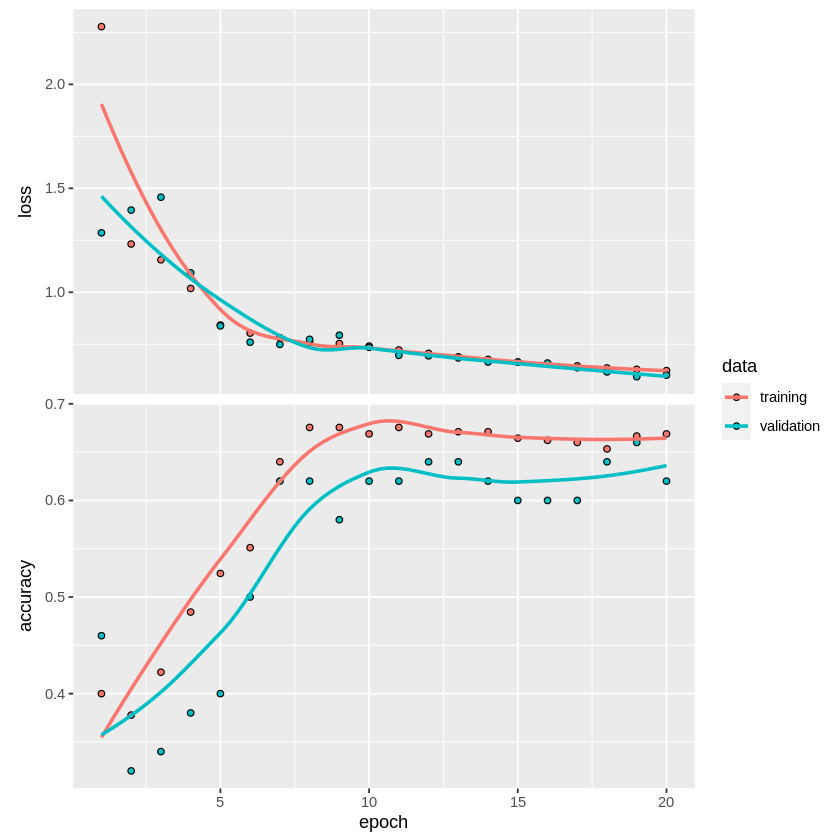

In [20]:
history <- model %>% 
  fit(
    x_train, y_train, 
    epochs = 20, 
    batch_size = 100, 
    validation_split = 0.10
  )
plot(history)

## Evaluación del modelo

In [21]:
x_val <- val %>%
  select(-Survived) %>%
  data.matrix()

y_val <- val %>%
  select(Survived) %>%
  data.matrix()

model %>% evaluate(x_val, y_val)

loss  accuracy 
0.6175451 0.6588785

## Predicción


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




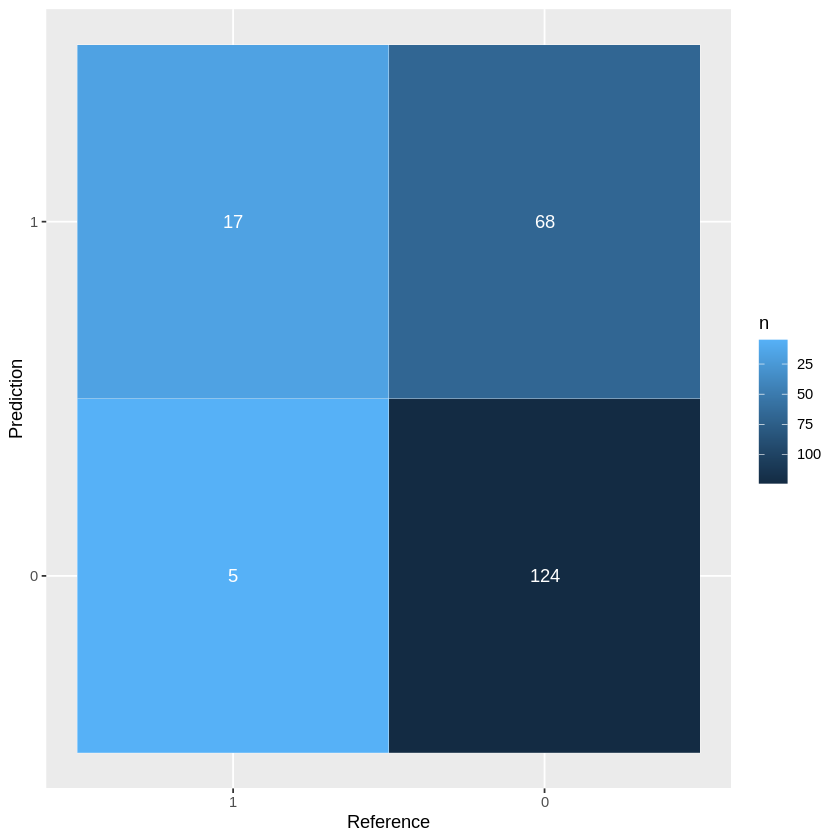

In [24]:
predictions <- model %>% 
  predict(x_val) %>% 
  `>`(0.5) %>% 
  k_cast("int32") %>%
  data.matrix()

cm <- confusionMatrix(as.factor(y_val), as.factor(predictions))
cm_prop <- prop.table(cm$table)

library(scales)
cm_tibble <- as_tibble(cm$table) 

ggplot(data = cm_tibble) + 
  geom_tile(aes(x=Reference, y=Prediction, fill=n), colour = "white") +
  geom_text(aes(x=Reference, y=Prediction, label=n), colour = "white") +
  scale_fill_continuous(trans = 'reverse') +
  scale_x_discrete(limits=rev)